Submitted By:
1. Linoy Ohayon - 316016369
2. Maayan Gueta - 206946105
3. Nave Cohen Lasry - 207022823

# Project - Part A

In [200]:
import gensim # text as vectors library

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import os
import random

from typing import Optional

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

## Preparing the datasets

In [201]:
# reading neg files and split to train and validation
data_neg_dir = "train/neg"
neg_train_x_files = []
neg_val_x_files = []

num_neg = 18750
files_read = 0
for (roots, dirs, files) in os.walk(data_neg_dir): 
    for file_dir in files:
        file = open(roots + f'/{file_dir}', 'r', encoding = 'utf-8')
        if files_read <= 0.75 * num_neg: # train set          
            neg_train_x_files.append(file.readlines()[0])
        else: # validation set          
            neg_val_x_files.append(file.readlines()[0])
        file.close()
        files_read += 1

In [202]:
print(len(neg_train_x_files))
print(len(neg_val_x_files))

14063
4687


In [203]:
# reading pos files and split to train and validation
data_pos_dir = "train/pos"
pos_train_x_files = []
pos_val_x_files = []

num_pos = 18750
files_read = 0
for (roots, dirs, files) in os.walk(data_pos_dir): 
    for file_dir in files:
        file = open(roots + f'/{file_dir}', 'r', encoding = 'utf-8')
        if files_read <= 0.75 * num_pos: # train set          
            pos_train_x_files.append(file.readlines()[0])
        else: # validation set          
            pos_val_x_files.append(file.readlines()[0])
        file.close()
        files_read += 1

In [204]:
print(len(pos_train_x_files))
print(len(pos_val_x_files))

14063
4687


In [205]:
# create y vectors for all datasets created above
neg_train_y_files = [0] * len(neg_train_x_files)
neg_val_y_files = [0] * len(neg_val_x_files)
pos_train_y_files = [1] * len(pos_train_x_files)
pos_val_y_files = [1] * len(pos_val_x_files)

In [206]:
# concatenate all train x datasets and all y datasets
train_x = neg_train_x_files + pos_train_x_files
train_y = neg_train_y_files + pos_train_y_files

# shuffle the data
train = list(zip(train_x, train_y))
random.shuffle(train)

train_x, train_y = zip(*train)

    
# concatenate all val x datasets and all y datasets
val_x = neg_val_x_files + pos_val_x_files
val_y = neg_val_y_files + pos_val_y_files

# shuffle the data
val = list(zip(val_x, val_y))
random.shuffle(val)

val_x, val_y = zip(*val)
    
    
# concatenate all x datasets to train models
all_x = train_x + val_x


# chage type to numpy
train_x = np.array(train_x)
train_y = np.array(train_y)
val_x = np.array(val_x)
val_y = np.array(val_y)
all_x = np.array(all_x)


# cleaning all data from <br />
for review in range(len(train_x)):
    train_x[review] = train_x[review].replace("<br /><br />", " ")
    train_x[review] = train_x[review].replace("<br />", " ")

for review in range(len(val_x)):
    val_x[review] = val_x[review].replace("<br /><br />", " ")
    val_x[review] = val_x[review].replace("<br />", " ")

for review in range(len(all_x)):
    all_x[review] = all_x[review].replace("<br /><br />", " ")
    all_x[review] = all_x[review].replace("<br />", " ")

## Implementing a GRU net

In [207]:
class GRU(nn.Module):

    def __init__(self, input_size: int, hidden_size: int):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.activation = F.relu
        
        # initialize tensors to random weights
        wr_empty_tensor = torch.empty(self.input_size, self.hidden_size)
        wz_empty_tensor = torch.empty(self.input_size, self.hidden_size)
        wh_empty_tensor = torch.empty(self.input_size, self.hidden_size)
        ur_empty_tensor = torch.empty(self.hidden_size, self.hidden_size)
        uz_empty_tensor = torch.empty(self.hidden_size, self.hidden_size)
        uh_empty_tensor = torch.empty(self.hidden_size, self.hidden_size)  
        
        # Weights for input vectors of shape (input_size, hidden_size)
        self.Wr = torch.autograd.Variable(torch.nn.init.trunc_normal_(wr_empty_tensor, mean=0, std=0.01), name='Wr')
        self.Wz = torch.autograd.Variable(torch.nn.init.trunc_normal_(wz_empty_tensor, mean=0, std=0.01), name='Wz')
        self.Wh = torch.autograd.Variable(torch.nn.init.trunc_normal_(wh_empty_tensor, mean=0, std=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Ur = torch.autograd.Variable(torch.nn.init.trunc_normal_(ur_empty_tensor, mean=0, std=0.01), name='Ur')
        self.Uz = torch.autograd.Variable(torch.nn.init.trunc_normal_(uz_empty_tensor, mean=0, std=0.01), name='Uz')
        self.Uh = torch.autograd.Variable(torch.nn.init.trunc_normal_(uh_empty_tensor, mean=0, std=0.01), name='Uh')
         
        # Define fc layer
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 1), nn.Sigmoid())
        
        
    def forward_pass(self, input_embeddings):
        outputs, hidden_states = [], []
             
        # Initialize hidden output with zeros.
        hidden = torch.zeros(self.hidden_size, dtype=torch.float32)
        hidden = torch.reshape(hidden, (1, self.hidden_size))
            
        # each word of the paragraph gets into the net
        for val in input_embeddings:  
            x_t = val  
            x_t = torch.reshape(x_t, (1, self.input_size))

            # Definitions of z_t and r_t          
            z_t = torch.sigmoid(torch.matmul(x_t, self.Wz) + torch.matmul(hidden, self.Uz))
            r_t = torch.sigmoid(torch.matmul(x_t, self.Wr) + torch.matmul(hidden, self.Ur))

            # Definition of h~_t
            h_proposal = torch.tanh(torch.matmul(x_t, self.Wh) + torch.matmul(torch.multiply(r_t, hidden), self.Uh))
        
            # Compute the next hidden state
            h_t = torch.multiply(z_t, hidden) + torch.multiply(1-z_t, h_proposal)
            h_t = torch.reshape(h_t, (1, self.hidden_size))
            
            hidden = h_t      
            
            hidden_states.append(h_t)
            output = self.activation(h_t)
            outputs.append(output)
         
        probability = self.fc(outputs[-1])

        return probability

## Define Embeddings

In [208]:
### preperations to training embeddings
new_sentences = [review.split() for review in all_x] # learn all the data we have
print("done preperation")


### embedding type 1
# loading pre-trained model and keep training
WORD_2_VEC_PATH = 'word2vec.model'
model_1 = gensim.models.Word2Vec.load(WORD_2_VEC_PATH) # Load word2vec pre-trained model

model_1.build_vocab(new_sentences, update=True)  # Update the vocabulary
model_1.train(new_sentences, total_examples=len(new_sentences), epochs=10)

weights_1 = torch.FloatTensor(model_1.wv.vectors) # pre trained weights
print('weights_1.shape - ', weights_1.shape)

# Build nn.Embedding() layer
embedding_1 = nn.Embedding.from_pretrained(weights_1)
  
# embedding function 1
def embedding_type_1(query):    
    input_ids = torch.LongTensor([model_1.wv.get_index(token) for token in query.split()])
    input_embeddings = embedding_1(input_ids)    
    return input_embeddings



### embedding type 2
# building vocabulary
model_2 = gensim.models.FastText(vector_size=100, window=3, min_count=1)  # instantiate
model_2.build_vocab(new_sentences) # build the vocabulary
model_2.train(new_sentences, total_examples=len(new_sentences), epochs=10) # train

weights_2 = torch.FloatTensor(model_2.wv.vectors) # pre trained weights

print('weights_2.shape - ', weights_2.shape)

# Build nn.Embedding() layer
embedding_2 = nn.Embedding.from_pretrained(weights_2)

# embedding function 2
def embedding_type_2(query):
    input_ids = torch.LongTensor([model_2.wv.get_index(token) for token in query.split()])
    input_embeddings = embedding_2(input_ids)
    
    return input_embeddings


done preperation
weights_1.shape -  torch.Size([345449, 100])
weights_2.shape -  torch.Size([343653, 100])


## Training

In [209]:
def training(embedding_type):
    # number of epochs to train the model
    n_epochs = 10

    epoch_loss = [] # the list will hold all the losses - to build graph
    epoch_train_accuracy = [] # the list will hold all Accuracy values for each train epoch - to build graph
    epoch_val_accuracy = [] # the list will hold all Accuracy values for each test epoch - to build graph

    net = GRU(input_size=100, hidden_size=50) 
    
    # Define loss function and optimizer:
    loss_function = nn.BCELoss()
    learning_rate = 0.01
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        
    train_y_tensor = torch.from_numpy(train_y)
    
    epoch_num = 0
    for epoch in range(1, n_epochs+1):    
        # train the model  
        net.train()
                
        epoch_tr_loss = 0
        epoch_val_acc = 0
        epoch_tr_acc = 0
        
        for review_val in range(len(val_x)):
            if embedding_type == 1:
                review_embedding = embedding_type_1(val_x[review_val])
            else:
                review_embedding = embedding_type_2(val_x[review_val])
                               
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs_val = net.forward_pass(review_embedding) # predicted probabilities of test data
        
            # accuracy calculation
            correct_val = np.sum(torch.squeeze(outputs_val).round().detach().numpy()) == val_y[review_val]
            val_accuracy = np.array(correct_val * 100)
    
            val_accuracy = torch.from_numpy(val_accuracy)
            
            # sum all reviews accuracies
            epoch_val_acc += val_accuracy
                            
                                 
        for review in range(len(train_x)):
            if embedding_type == 1:
                review_embedding = embedding_type_1(train_x[review])
            else:
                review_embedding = embedding_type_2(train_x[review])
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            outputs_train = net.forward_pass(review_embedding)

            # accuracy calculation
            correct_train = np.sum(torch.squeeze(outputs_train).round().detach().numpy()) == train_y[review]
            train_accuracy = np.array(correct_train * 100)
                        
            train_accuracy = torch.from_numpy(train_accuracy)      
            
            train_y_tensor_ = torch.reshape(train_y_tensor[review], (1,1))
            train_y_tensor_ = train_y_tensor_.type(torch.float32)
            
            # calculate the loss
            loss = loss_function(outputs_train, train_y_tensor_)
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
                      
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            # sum all reviews loss
            epoch_tr_loss += loss     
                   
            # sum all reviews accuracies
            epoch_tr_acc += train_accuracy

            
        # average of all reviews loss & accuracies                 
        epoch_loss.append(epoch_tr_loss.item() / len(train_x)) 
        epoch_train_accuracy.append(epoch_tr_acc.item() / len(train_x)) 
        epoch_val_accuracy.append(epoch_val_acc.item() / len(val_x)) 
        
        epoch_num += 1
        print('epoch ended - ', epoch_num)
                                  
    return epoch_loss, epoch_train_accuracy, epoch_val_accuracy

In [210]:
# training our net on both embeddings
epoch_loss_1, epoch_train_accuracy_1, epoch_val_accuracy_1 = training(1)
epoch_loss_2, epoch_train_accuracy_2, epoch_val_accuracy_2 = training(2)

epoch ended -  1
epoch ended -  2
epoch ended -  3
epoch ended -  4
epoch ended -  5
epoch ended -  6
epoch ended -  7
epoch ended -  8
epoch ended -  9
epoch ended -  10
epoch ended -  1
epoch ended -  2
epoch ended -  3
epoch ended -  4
epoch ended -  5
epoch ended -  6
epoch ended -  7
epoch ended -  8
epoch ended -  9
epoch ended -  10


In [218]:
print('epoch_loss_1 - \n', epoch_loss_1)
print('--')
print('epoch_train_accuracy_1 - \n', epoch_train_accuracy_1)
print('--')
print('epoch_val_accuracy_1 - \n', epoch_val_accuracy_1)

print('2')
print('epoch_loss_2 - \n', epoch_loss_2)
print('--')
print('epoch_train_accuracy_2 - \n',epoch_train_accuracy_2)
print('--')
print('epoch_val_accuracy_2 - \n', epoch_val_accuracy_2)

epoch_loss_1 - 
 [0.6735712591330086, 0.6688719817739813, 0.6687973316504302, 0.6688094145541492, 0.6688180253590983, 0.6688216363418189, 0.6688249001146626, 0.6688241362529332, 0.6688253862084904, 0.6688265667220721]
--
epoch_train_accuracy_1 - 
 [57.637061793358455, 58.97390315011022, 59.03790087463557, 59.06989973689824, 59.09123231174003, 59.09123231174003, 59.09123231174003, 59.10189859916092, 59.09834317002062, 59.09123231174003]
--
epoch_val_accuracy_1 - 
 [50.192020482184766, 58.9609558352891, 59.206315340302965, 59.120972903776405, 59.131640708342225, 59.152976317473865, 59.110305099210585, 59.110305099210585, 59.099637294644765, 59.099637294644765]
2
epoch_loss_2 - 
 [0.6786341346752115, 0.6742229720721041, 0.6740719357756169, 0.6740634638546185, 0.6740701302842566, 0.674074574570682, 0.6740790882990827, 0.6740886712916874, 0.6740938794398421, 0.6741011708472587]
--
epoch_train_accuracy_2 - 
 [57.096636564033275, 58.437033349925336, 58.593472232098414, 58.593472232098414, 58.

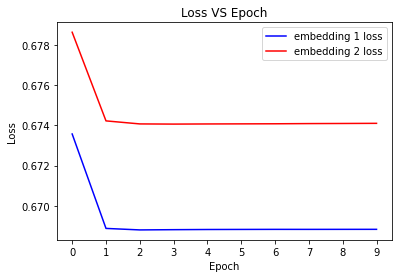

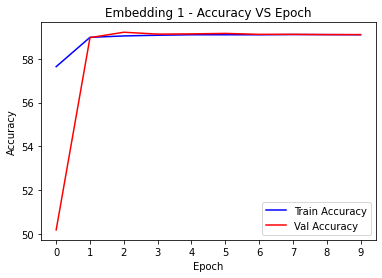

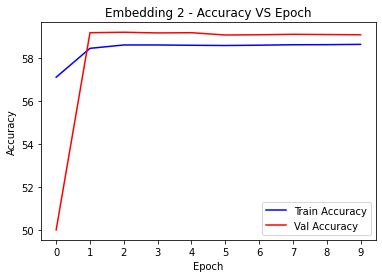

In [212]:
### Graphs
# embedding_1 & embedding_2 loss plot per epoch
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(epoch_loss_1, c='b',label="embedding 1 loss");
ax.plot(epoch_loss_2, c='r',label="embedding 2 loss");
ax.set_title('Loss VS Epoch')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend()
plt.show()

# embedding 1 - train & val accuracy plot per epoch
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(epoch_train_accuracy_1, c='b',label="Train Accuracy");
ax.plot(epoch_val_accuracy_1, c='r',label="Val Accuracy");
ax.set_title('Embedding 1 - Accuracy VS Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.legend()
plt.show()

# embedding 2 - train & val accuracy plot per epoch
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(epoch_train_accuracy_2, c='b',label="Train Accuracy");
ax.plot(epoch_val_accuracy_2, c='r',label="Val Accuracy");
ax.set_title('Embedding 2 - Accuracy VS Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
### Graphs
# embedding_1 & embedding_2 loss plot per epoch
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(epoch_loss_1, c='b',label="embedding 1 loss");
ax.plot(epoch_loss_2, c='r',label="embedding 2 loss");
ax.set_title('Loss VS Epoch')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend()
plt.show()

# embedding 1 - train & val accuracy plot per epoch
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(epoch_train_accuracy_1, c='b',label="Train Accuracy");
ax.plot(epoch_val_accuracy_1, c='r',label="Val Accuracy");
ax.set_title('Embedding 1 - Accuracy VS Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.legend()
plt.show()

# embedding 2 - train & val accuracy plot per epoch
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(epoch_train_accuracy_2, c='b',label="Train Accuracy");
ax.plot(epoch_val_accuracy_2, c='r',label="Val Accuracy");
ax.set_title('Embedding 2 - Accuracy VS Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.legend()
plt.show()

## Checking sanity of graphs

Check training on 100 reviews from train set & 100 reviews from val set

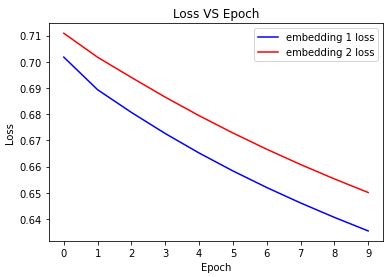
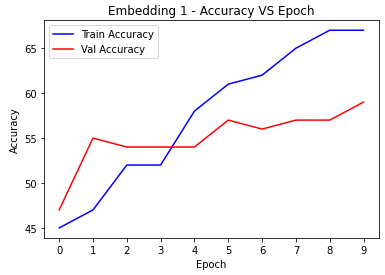
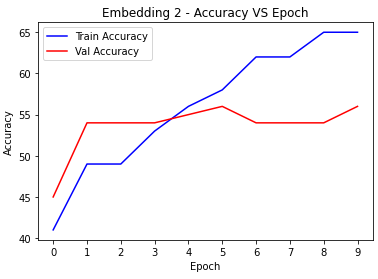

Check training on 4500 reviews from train set & 1500 reviews from val set

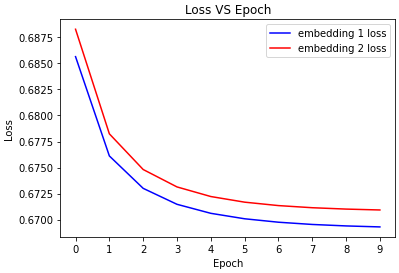
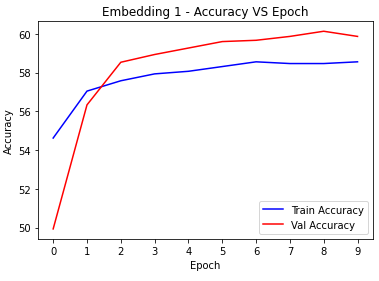
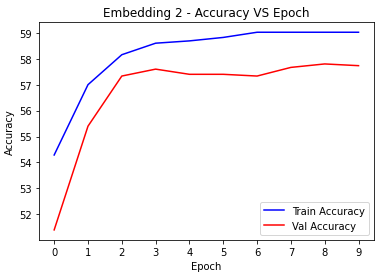